## Importamos las librerías

In [207]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tensorflow.keras import layers, models


### Cargamos csv

In [208]:
df = pd.read_csv("Libro3.csv", sep=';', encoding='latin1')

### Comenzamos EDA

**Hacemos un análisis de las columnas.**

In [209]:
df.head()

,Perfume,Brand,Gender,Rating Value,Rating Count,Year,Top,Middle,Base,mainaccord1,mainaccord2,mainaccord3,mainaccord4,mainaccord5
0,accento-overdose-pride-edition,xerjoff,unisex,"1,42",201,2022,"fruity notes, aldehydes, green notes","bulgarian rose, egyptian jasmine, lily-of-the-...","eucalyptus, pine",rose,woody,fruity,aromatic,floral
1,classique-pride-2024,jean-paul-gaultier,women,"1,86",70,2024,"yuzu, citruses","orange blossom, neroli","musk, blonde woods",citrus,white floral,sweet,fresh,musky
2,classique-pride-2023,jean-paul-gaultier,unisex,"1,91",285,2023,"blood orange, yuzu","neroli, orange blossom","musk, white woods",citrus,white floral,sweet,fresh spicy,musky
3,pride-edition-man,bruno-banani,men,"1,92",59,2019,"guarana, grapefruit, red apple","walnut, lavender, guava","vetiver, benzoin, amber",fruity,nutty,woody,tropical,NaN
4,le-male-pride-collector,jean-paul-gaultier,men,"1,93",632,2020,"mint, lavender, cardamom, artemisia, bergamot","caraway, cinnamon, orange blossom","vanilla, sandalwood, amber, cedar, tonka bean",aromatic,warm spicy,fresh spicy,cinnamon,vanilla


In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12705 entries, 0 to 12704
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Perfume       12705 non-null  object
 1   Brand         12705 non-null  object
 2   Gender        12705 non-null  object
 3   Rating Value  12705 non-null  object
 4   Rating Count  12705 non-null  int64 
 5   Year          12705 non-null  int64 
 6   Top           12705 non-null  object
 7   Middle        12705 non-null  object
 8   Base          12705 non-null  object
 9   mainaccord1   12705 non-null  object
 10  mainaccord2   12700 non-null  object
 11  mainaccord3   12644 non-null  object
 12  mainaccord4   12507 non-null  object
 13  mainaccord5   12182 non-null  object
dtypes: int64(2), object(12)
memory usage: 1.4+ MB


Vemos que todas las columnas tiene valores de tipo 'objeto', a continuación comprobaremos los valores nulos.

In [211]:
df.isnull().sum()

Perfume           0
Brand             0
Gender            0
Rating Value      0
Rating Count      0
Year              0
Top               0
Middle            0
Base              0
mainaccord1       0
mainaccord2       5
mainaccord3      61
mainaccord4     198
mainaccord5     523
dtype: int64

Hay algunos valores nulos en los últimos acordes; para posteriormente hacer PCAs es necesario que no haya valores nulos, por lo que a estos imputaremos valores.

A la hora de imputar los valores imputar con valores como la mediana podría dar problemas en el anális posterior ya que este valor sería el de un aroma, lo que podría adulterar los datos sobre cada perfume, por lo que les daaremos el valor 'none' para que tras su posterior codificación tengan todos los valores nulos le mismo valor codificado.

In [212]:
df['mainaccord1'] = df['mainaccord1'].fillna('none')
df['mainaccord2'] = df['mainaccord2'].fillna('none')
df['mainaccord3'] = df['mainaccord3'].fillna('none')
df['mainaccord4'] = df['mainaccord4'].fillna('none')
df['mainaccord5'] = df['mainaccord5'].fillna('none')

Definimos las columnas mainaccord y las guardamos en main_cols:

In [213]:
main_cols = [c for c in df.columns if c.startswith('mainaccord')]
print("Columnas detectadas:", main_cols)

Columnas detectadas: ['mainaccord1', 'mainaccord2', 'mainaccord3', 'mainaccord4', 'mainaccord5']


Codificamos las columnas aplicando la misma condición a todas las columnas, si en la columna 1 el aroma 'x' tiene valor 1, en el resto de columnas también lo será.

In [214]:

ordered = []
for c in main_cols:
    for v in df[c].dropna().astype(str):
        if v not in ordered:
            ordered.append(v)

mapping = {v: i for i, v in enumerate(ordered, start=1)}  
print("Número de categorías encontradas:", len(mapping))
print("Ejemplo de mapping (primeros 10):", dict(list(mapping.items())[:10]))

for c in main_cols:
    df[c] = df[c].map(mapping)


Número de categorías encontradas: 81
Ejemplo de mapping (primeros 10): {'rose': 1, 'citrus': 2, 'fruity': 3, 'aromatic': 4, 'white floral': 5, 'woody': 6, 'powdery': 7, 'leather': 8, 'ozonic': 9, 'vinyl': 10}


In [215]:
df['Top'].head()

0             fruity notes, aldehydes, green notes
1                                   yuzu, citruses
2                               blood orange, yuzu
3                   guarana, grapefruit, red apple
4    mint, lavender, cardamom, artemisia, bergamot
Name: Top, dtype: object

In [216]:

##Ahora vamos a normalizar las notas de top, middle, base
def normalize_notes(notes):
    if not isinstance(notes, str):
        return []
    return [n.strip().lower() for n in notes.split(',') if n.strip()]

print(df['Top'].head())

df['Top'] = df['Top'].apply(normalize_notes)
df['Middle'] = df['Middle'].apply(normalize_notes)
df['Base'] = df['Base'].apply(normalize_notes)

0             fruity notes, aldehydes, green notes
1                                   yuzu, citruses
2                               blood orange, yuzu
3                   guarana, grapefruit, red apple
4    mint, lavender, cardamom, artemisia, bergamot
Name: Top, dtype: object


In [217]:
##Contruimos vocabulario global de notas:

all_notes = set()

for col in ['Top', 'Middle', 'Base']:
    df[col].apply(lambda x: all_notes.update(x))

all_notes = sorted(all_notes)
print(len(all_notes))

1502


In [218]:
note_to_idx = {note: i for i, note in enumerate(all_notes)}
print(note_to_idx)

{'absinthe': 0, 'acai berry': 1, 'accord eudora©': 2, 'acerola': 3, 'acerola blossom': 4, 'acetylfuran': 5, 'ac\xa0cia': 6, 'african geranium': 7, 'african ginger': 8, 'african orange flower': 9, 'agarwood': 10, 'agarwood (oud)': 11, 'agave': 12, 'agave nectar': 13, 'aglaia': 14, 'akigalawood': 15, 'aldehydes': 16, 'algae': 17, 'allspice': 18, 'almond': 19, 'almond blossom': 20, 'almond cream': 21, 'almond milk': 22, 'almond tree': 23, 'aloe vera': 24, 'alpinia': 25, 'althaea': 26, 'alumroot': 27, 'amalfi lemon': 28, 'amaretto': 29, 'amaryllis': 30, 'amazon lily': 31, 'amber': 32, 'amber oil': 33, 'amber xtreme': 34, 'ambergris': 35, 'ambertonic': 36, 'amberwood': 37, 'ambrarome': 38, 'ambreine': 39, 'ambretone': 40, 'ambrette': 41, 'ambrette (musk mallow)': 42, 'ambrettolide': 43, 'ambrocenide': 44, 'ambrofix?': 45, 'ambrostar?': 46, 'ambrox super': 47, 'ambroxan': 48, 'amyl salicylate': 49, 'amyris': 50, 'angelica': 51, 'angels trumpet': 52, 'animal notes': 53, 'anise': 54, 'antillon

In [219]:
##Definimos pesos
WEIGHTS = {
    'top': 0.9,
    'middle': 0.7,
    'base': 0.4
}


In [220]:
#Vectorizamos perfumes

def build_weighted_perfume(row, note_to_idx, weights):
    vec = np.zeros(len(note_to_idx))

    for n in row['Top']:
        if n in note_to_idx:
            vec[note_to_idx[n]] += weights['top']

    for n in row['Middle']:
        if n in note_to_idx:
            vec[note_to_idx[n]] += weights['middle']
    
    for n in row['Base']:
        if n in note_to_idx:
            vec[note_to_idx[n]] += weights['base']

    return vec


In [221]:
##Creacion matriz completa de las notas

X_notes = np.vstack(df.apply(lambda row: build_weighted_perfume(row, note_to_idx, WEIGHTS), axis=1))

print(X_notes.shape)

(12705, 1502)


In [222]:
#Verificamos dimensiones
print(X_notes.shape)
print(df.shape)


(12705, 1502)
(12705, 14)


In [223]:
accord_cols = [
    'mainaccord1',
    'mainaccord2',
    'mainaccord3',
    'mainaccord4',
    'mainaccord5'
]


In [224]:
def normalize_accord(a):
    if not isinstance(a, str):
        return None
    return a.strip().lower()


In [225]:
def normalize_accord(a):
    if pd.isna(a):
        return None
    return str(a).strip().lower()


In [226]:
for col in accord_cols:
    df[col] = df[col].apply(normalize_accord)


In [227]:
accord_vocab = set()

for col in accord_cols:
    accord_vocab.update(df[col].dropna().unique())

accord_vocab = sorted(accord_vocab)
len(accord_vocab), accord_vocab[:10]


(81, ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18'])

In [228]:
df['Rating Value'] = pd.to_numeric(df['Rating Value'], errors='coerce')

En el histograma podemos ver que los primeros aromas son los mas repetidos, este patrón se repite en todas las columnas menos en la última, donde el aroma n65 tiene también gran importancia.

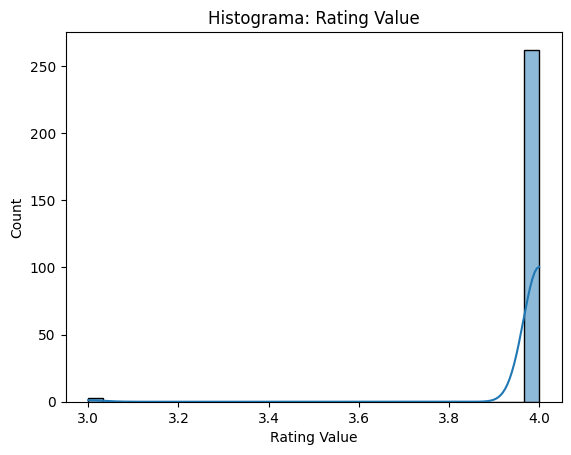

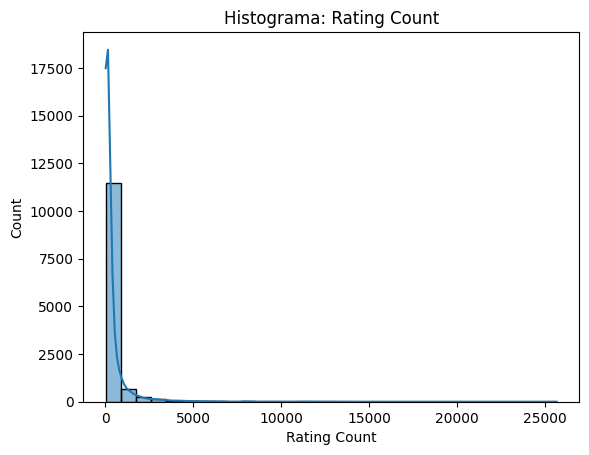

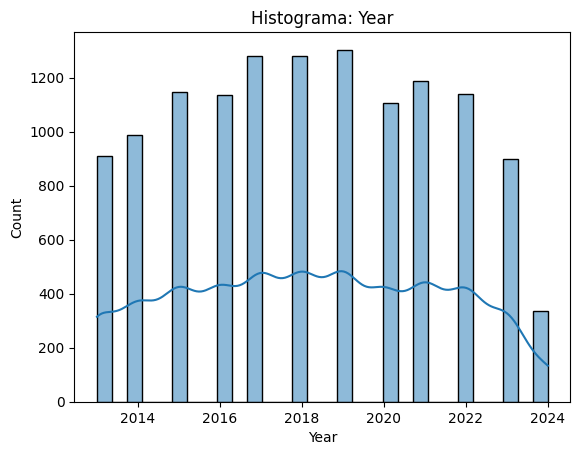

In [229]:
if "num_df" not in globals():
    num_df = df.select_dtypes(include=[np.number])
for col in num_df.columns:
    sns.histplot(df[col].dropna(), bins=30, kde=True)
    plt.title(f'Histograma: {col}')
    plt.show()

**Matriz de correlación**

In [230]:
num_df = df.select_dtypes(include=[np.number])
corr = num_df.corr()
corr

,Rating Value,Rating Count,Year
Rating Value,1.000000,0.037365,-0.114986
Rating Count,0.037365,1.000000,-0.084040
Year,-0.114986,-0.084040,1.000000


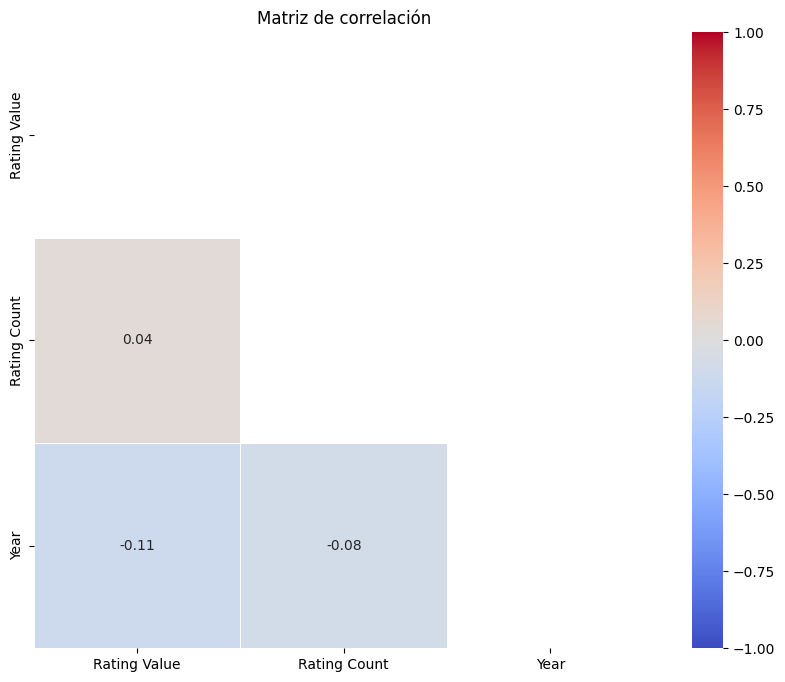

In [231]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))  
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            vmin=-1, vmax=1, linewidths=.5)
plt.title("Matriz de correlación")
plt.show()

Se puede ver que las columnas no tienen gran correlación entre si. Esto no tiene porque ser excluyente de realizar una correcta predicción como comprobaremos posteriormente.

**PCA**

Definimos las features para el PCA:

In [232]:
features = ["mainaccord1","mainaccord2","mainaccord3","mainaccord4","mainaccord5"]
X = df[features].copy()


Normalizamos los datos: 

In [233]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Queremos encontrar la cantidad justa de PCAs para explicar un 80%-90% de la varianza.

In [234]:
pca = PCA(n_components=4, random_state=0)
pcs = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(pcs, columns=["PC1","PC2","PC3","PC4"], index=X.index)
# add the imputed feature columns so they match the PCA input
for col in features:
	pca_df[col] = X[col].values

pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum()

(array([0.23586662, 0.20377729, 0.19749415, 0.18968294]),
 np.float64(0.8268209973430771))

Finalmente usaremos 4 componentes

In [235]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=features,
    columns=["PC1","PC2","PC3","PC4"]
)
loadings


,PC1,PC2,PC3,PC4
mainaccord1,-0.191590,-0.637540,0.609431,0.430049
mainaccord2,-0.031643,0.763521,0.517620,0.381795
mainaccord3,0.431306,-0.053414,-0.464984,0.771176
mainaccord4,0.623716,-0.075841,0.245647,-0.218915
mainaccord5,0.622291,-0.044425,0.290019,-0.163263


Realizamos una matriz para analizar que componentes afectan mas a cada aroma.

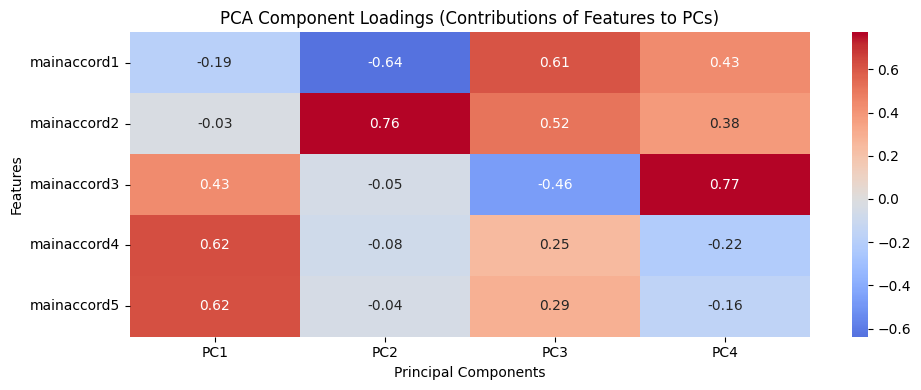

In [236]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=features,
    columns=[f"PC{i}" for i in range(1, pca.n_components_ + 1)]
)

plt.figure(figsize=(10, 4))
sns.heatmap(
    loadings,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("PCA Component Loadings (Contributions of Features to PCs)")
plt.ylabel("Features")
plt.xlabel("Principal Components")
plt.tight_layout()
plt.show()


Podemos ver en la matriz que el PC1 tiene gran influencia en los últimos acordes, mientras que la columna PC2 afecta principalmente los primeros acordes. La tercera columna influye sobre el 3 acorde principalmente y la última columna (PC4) tiene gran influencia positiva y negativa en los 2 primeros acordes afectando tamvién al resto de acordes levemente.

**Fin del EDA**

**Comienzo de la predicción**

In [237]:
def crear_modelo_perfume(n_perfumes):
    user_input = layers.Input(shape=(4,), name="User_Preferences")
    
    perfume_input = layers.Input(shape=(4,), name="Perfume_Features")
    
    combined = layers.Concatenate()([user_input, perfume_input])
    
    # Capas densas para aprender la relación (Regresión)
    x = layers.Dense(32, activation='relu')(combined)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dense(8, activation='relu')(x)
    
    
    output = layers.Dense(1, activation='sigmoid', name="Score")(x)
    
    model = models.Model(inputs=[user_input, perfume_input], outputs=output)
    model.compile(optimizer='adam', loss='mse') # Mean Squared Error para regresión
    return model

In [238]:
# Preparamos el dataset final para la red
final_dataset = pca_df[['PC1', 'PC2', 'PC3', 'PC4']].copy()
final_dataset['perfume_id'] = range(len(final_dataset))
final_dataset['name'] = df['Perfume']

print("Dataset listo para la red neuronal:")
print(final_dataset.head())

Dataset listo para la red neuronal:
        PC1       PC2       PC3       PC4  perfume_id  \
0 -0.725004  0.273959 -0.719184 -1.171529           0   
1 -0.350815  0.078985 -1.080691 -0.567130           1   
2  0.213755  0.010335 -0.858339 -0.765286           2   
3  2.679202  2.655993  2.740975 -0.540572           3   
4  2.037453  0.163408 -0.188488 -0.239933           4   

                             name  
0  accento-overdose-pride-edition  
1            classique-pride-2024  
2            classique-pride-2023  
3               pride-edition-man  
4         le-male-pride-collector  


In [239]:

def generardatosentrenamiento(pcadata, nejemplos=20000):
    userprefs = np.random.uniform(-3, 3, (nejemplos, 4))
    idx = np.random.choice(len(pcadata), nejemplos)
    perf = pcadata.iloc[idx].values
    
    y = np.array([cosine_similarity(userprefs[i].reshape(1,-1),
                                   perf[i].reshape(1,-1))[0,0]
                  for i in range(nejemplos)])

    # Si quieres 0..1 (porque usas sigmoid), reescala:
    y = (y + 1) / 2
    return userprefs, perf, y


In [240]:
Xuser, Xperfume, yscores = generardatosentrenamiento(final_dataset[['PC1','PC2','PC3','PC4']])

In [ ]:
# Creamos y entrenamos el modelo que definiste antes
# Asegúrate de crear el modelo antes de llamar a fit
model = crear_modelo_perfume(n_perfumes=final_dataset.shape[0])

history = model.fit([Xuser, Xperfume], yscores, epochs=20, batch_size=32, validation_split=0.2)


In [ ]:
def recomendar_perfumes(mis_preferencias, pca_data, original_df, top_n=5):
    # Preparamos el vector del usuario (repetido para comparar con todos los perfumes)
    user_input = np.tile(mis_preferencias, (len(pca_data), 1))
    perfume_input = pca_data[['PC1', 'PC2', 'PC3', 'PC4']].values
    
    # La red predice el score para todos a la vez
    scores = model.predict([user_input, perfume_input])
    
    # Añadimos los scores al dataframe original para ver nombres
    resultados = original_df.copy()
    resultados['match_score'] = scores
    
    return resultados.sort_values(by='match_score', ascending=False).head(top_n)

In [ ]:
# Ejemplo: Me gusta mucho lo limpio (2) y lo intenso (2), pero odio lo cálido (-2)
mis_gustos = np.array([2.0, -2.0, 0.5, 2.0]) 

top_recomendaciones = recomendar_perfumes(mis_gustos, pca_df, df)
print(top_recomendaciones[['Perfume', 'Brand', 'match_score']]) 

398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
                      Perfume                    Brand  match_score
498                la-piscine             miguel-matos     0.965871
9490                free-hugs              o-boticario     0.965729
4678  blue-oia-vanille-muguet  la-maison-de-la-vanille     0.960604
3195          lucia-starlight                 oriflame     0.960563
9263                 disumano                    morph     0.958087


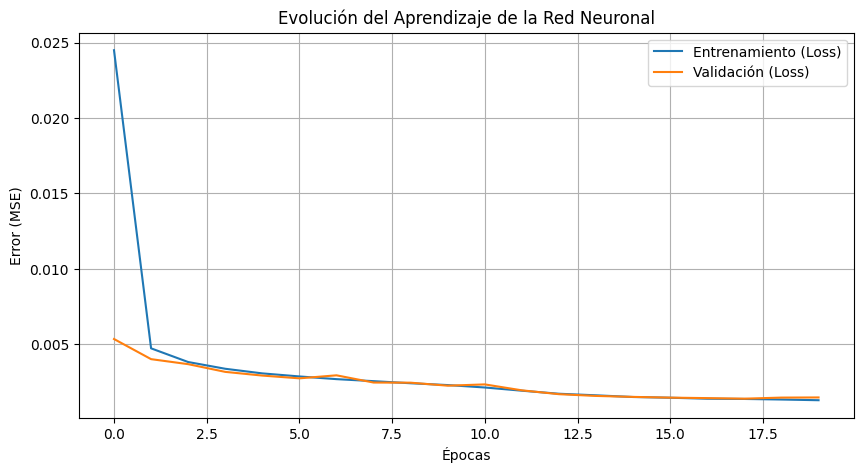

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Entrenamiento (Loss)')
plt.plot(history.history['val_loss'], label='Validación (Loss)')
plt.title('Evolución del Aprendizaje de la Red Neuronal')
plt.xlabel('Épocas')
plt.ylabel('Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

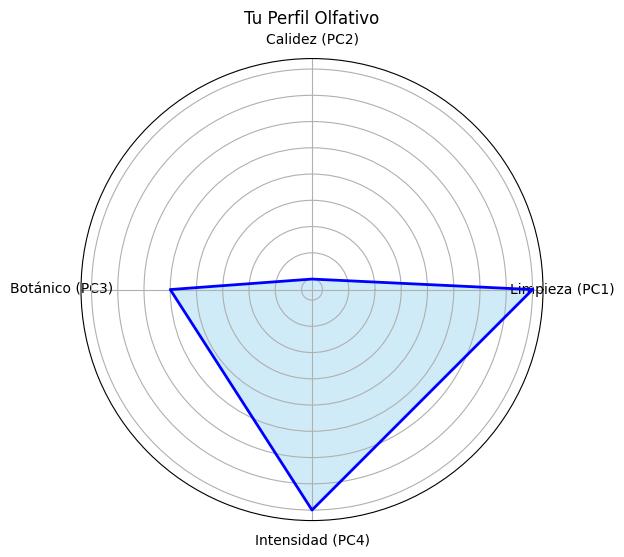

In [ ]:
import numpy as np

def graficar_perfil_usuario(gustos):
    labels = ['Limpieza (PC1)', 'Calidez (PC2)', 'Botánico (PC3)', 'Intensidad (PC4)']
    # Cerramos el gráfico circular
    stats = np.concatenate((gustos, [gustos[0]]))
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.fill(angles, stats, color='skyblue', alpha=0.4)
    ax.plot(angles, stats, color='blue', linewidth=2)
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    plt.title("Tu Perfil Olfativo")
    plt.show()

# Ejemplo con tus gustos anteriores
graficar_perfil_usuario(mis_gustos)

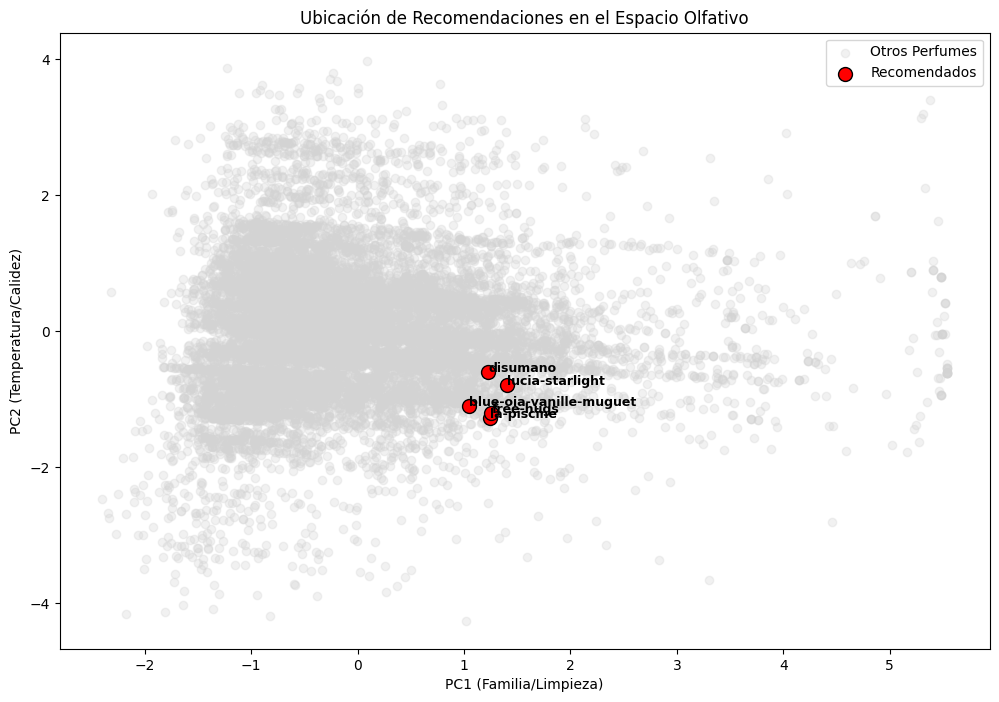

In [ ]:
def graficar_recomendaciones(pca_df, recomendados_df):
    plt.figure(figsize=(12, 8))
    
    # Todos los perfumes de fondo
    plt.scatter(pca_df['PC1'], pca_df['PC2'], c='lightgrey', alpha=0.3, label='Otros Perfumes')
    
    # Resaltar los recomendados
    recom_pca = pca_df.loc[recomendados_df.index]
    plt.scatter(recom_pca['PC1'], recom_pca['PC2'], c='red', s=100, edgecolors='black', label='Recomendados')
    
    # Etiquetas de nombres
    for i, txt in enumerate(recomendados_df['Perfume']):
        plt.annotate(txt, (recom_pca['PC1'].iloc[i], recom_pca['PC2'].iloc[i]), fontsize=9, fontweight='bold')
        
    plt.xlabel('PC1 (Familia/Limpieza)')
    plt.ylabel('PC2 (Temperatura/Calidez)')
    plt.title('Ubicación de Recomendaciones en el Espacio Olfativo')
    plt.legend()
    plt.show()

graficar_recomendaciones(pca_df, top_recomendaciones)

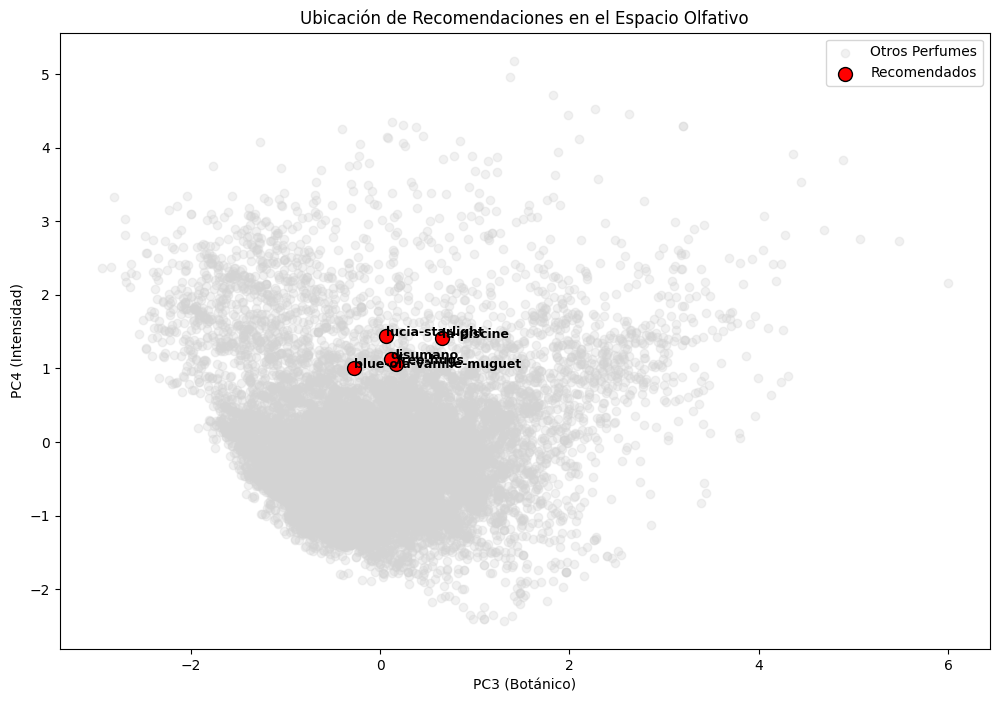

In [ ]:
def graficar_recomendaciones(pca_df, recomendados_df):
    plt.figure(figsize=(12, 8))
    
    # Todos los perfumes de fondo
    plt.scatter(pca_df['PC3'], pca_df['PC4'], c='lightgrey', alpha=0.3, label='Otros Perfumes')
    
    # Resaltar los recomendados
    recom_pca = pca_df.loc[recomendados_df.index]
    plt.scatter(recom_pca['PC3'], recom_pca['PC4'], c='red', s=100, edgecolors='black', label='Recomendados')
    
    # Etiquetas de nombres
    for i, txt in enumerate(recomendados_df['Perfume']):
        plt.annotate(txt, (recom_pca['PC3'].iloc[i], recom_pca['PC4'].iloc[i]), fontsize=9, fontweight='bold')
        
    plt.xlabel('PC3 (Botánico)')
    plt.ylabel('PC4 (Intensidad)')
    plt.title('Ubicación de Recomendaciones en el Espacio Olfativo')
    plt.legend()
    plt.show()

graficar_recomendaciones(pca_df, top_recomendaciones)

In [ ]:
def recomendar_con_filtro(mis_preferencias, pca_data, original_df, genero=None, top_n=5):
    # Copia de los datos para no afectar el original
    df_temp = original_df.copy()
    pca_temp = pca_data.copy()
    
    # Aplicar filtro de género si se solicita
    if genero:
        mask = df_temp['Gender'].isin(genero)
        df_temp = df_temp[mask]
        pca_temp = pca_temp[mask]
    
    # Preparar entrada para la red neuronal
    user_input = np.tile(mis_preferencias, (len(pca_temp), 1))
    perfume_input = pca_temp[['PC1', 'PC2', 'PC3', 'PC4']].values
    
    # Predicción
    scores = model.predict([user_input, perfume_input])
    df_temp['match_score'] = scores
    
    return df_temp.sort_values(by='match_score', ascending=False).head(top_n)

# Ejemplo de uso: Buscamos perfumes de Hombre o Unisex
mis_gustos = np.array([1.5, -0.5, 2.0, 1.0]) # Tu perfil
rec = recomendar_con_filtro(mis_gustos, pca_df, df, genero=['men', 'unisex'])
print(rec[['Perfume', 'Brand', 'Gender', 'match_score']])

239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
                 Perfume              Brand  Gender  match_score
7871              tulipe          le-galion  unisex     0.936513
11330         cherry-ink  lorenzo-pazzaglia  unisex     0.936339
11729  shaghaf-oud-tonka      swiss-arabian  unisex     0.933251
73           vanilla-sex           tom-ford  unisex     0.930279
10662     amarena-cherry          fragrenza  unisex     0.927936


In [ ]:
model.save('modelo_perfumes2.h5')
model.save("modelo_perfumes2.keras")
print("¡Modelo guardado con éxito como modelo_perfumes.h5!")

¡Modelo guardado con éxito como modelo_perfumes.h5!


In [ ]:
import joblib, json

joblib.dump(scaler, "scaler.joblib")
joblib.dump(pca, "pca.joblib")

with open("mapping.json", "w", encoding="utf-8") as f:
    json.dump(mapping, f, ensure_ascii=False)

print("Guardados: scaler.joblib, pca.joblib, mapping.json")


Guardados: scaler.joblib, pca.joblib, mapping.json
